In [5]:

import sys

sys.path.append('..')

import torch

from src.models.autoencoder import BasicAutoencoderKL

ddconfig = {
    "double_z": True,
    "z_channels": 4,
    "resolution": 512,
    "in_channels": 5,
    "out_ch": 5,
    "ch": 128,
    "ch_mult": [1, 2, 4, 8],
    "num_res_blocks": 2,
    "attn_resolutions": [],
    "dropout": 0.0
}

lossconfig = {"target": "torch.nn.Identity"}

vae = BasicAutoencoderKL(
    ddconfig=ddconfig,
    lossconfig=lossconfig,
    embed_dim=4,
    ckpt_path="../models/vae/vae.ckpt"  # Using the provided checkpoint path
)
vae.eval()  # Set to evaluation mode

making attention of type 'vanilla' with 1024 in_channels
Working with z of shape (1, 4, 64, 64) = 16384 dimensions.
making attention of type 'vanilla' with 1024 in_channels
Restored VAE from ../models/vae/vae.ckpt


BasicAutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(5, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          

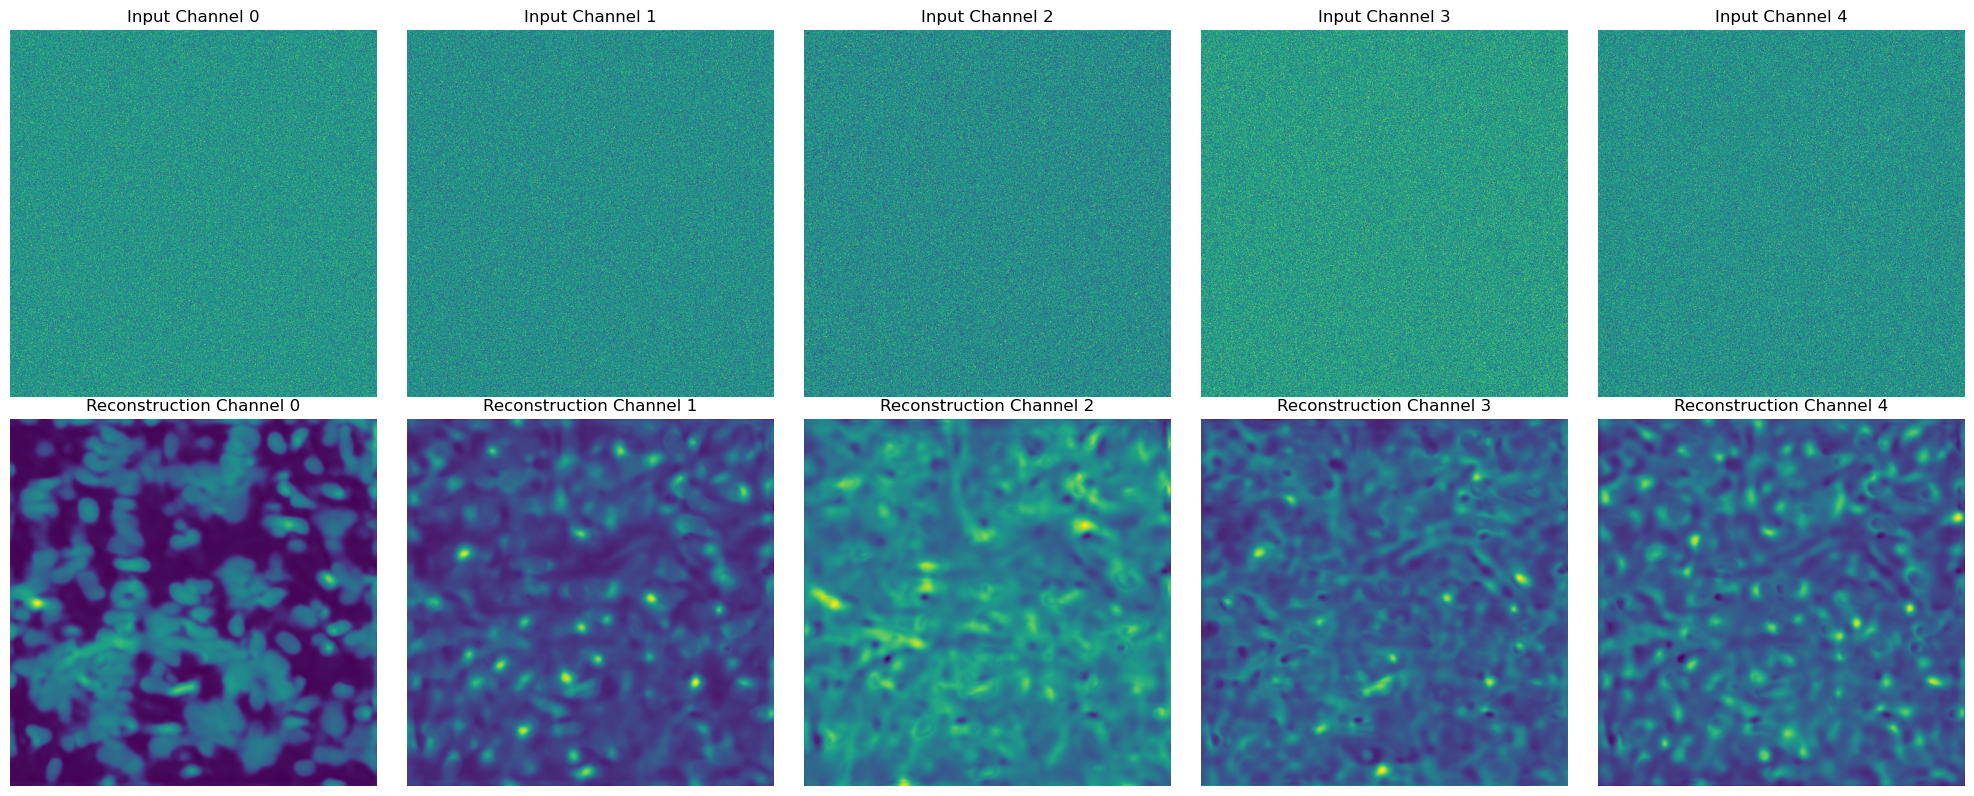

In [6]:
import matplotlib.pyplot as plt

# Create a sample input (batch_size=1, channels=5, height=512, width=512)
sample_input = torch.randn(1, 5, 512, 512)

with torch.no_grad():
    posterior = vae.encode(sample_input)
    latents = posterior.sample()
    reconstruction = vae.decode(latents)

    # Create a figure with 5 columns (one per channel) and 2 rows (input/output)
    plt.figure(figsize=(20, 8))

    for i in range(5):
        # Plot original channel
        plt.subplot(2, 5, i + 1)
        plt.imshow(sample_input[0, i].numpy())
        plt.title(f'Input Channel {i}')
        plt.axis('off')

        # Plot reconstructed channel
        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstruction[0, i].numpy())
        plt.title(f'Reconstruction Channel {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
import matplotlib.pyplot as plt
import torch
import webdataset as wds


def show_vae_reconstruction(n=0):
    """
    Show VAE reconstruction for the nth sample from the webdataset.
    Args:
        n (int): Index of the sample to show (default: 0)
    """
    # Setup webdataset
    WDS_DIR = "../data/webdataset"  # Adjust path as needed
    val_pattern = f"{WDS_DIR}/val/shard_{{000000..999999}}.tar"
    dataset = wds.WebDataset(val_pattern).decode()

    sample = None
    # Get nth sample
    for i, current_sample in enumerate(dataset):
        if i == n:
            sample = current_sample
            break

    if sample is None:
        raise ValueError(f"Sample {n} not found in dataset")

    with torch.no_grad():
        plt.figure(figsize=(20, 8))

        # Prepare input
        images = torch.from_numpy(sample['images.npy']).unsqueeze(0)

        # Get VAE reconstruction
        posterior = vae.encode(images)
        latents = posterior.sample()
        reconstruction = vae.decode(latents)

        # Plot all channels
        for i in range(5):
            # Plot original channel
            plt.subplot(2, 5, i + 1)
            plt.imshow(images[0, i].numpy(), cmap='gray', vmin=0, vmax=1)
            plt.title(f'Input Channel {i}')
            plt.axis('off')

            # Plot reconstructed channel
            plt.subplot(2, 5, i + 6)
            plt.imshow(reconstruction[0, i].numpy(), cmap='gray', vmin=0, vmax=1)
            plt.title(f'Reconstruction Channel {i}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Print metadata if available
        if 'meta.json' in sample:
            print("\nMetadata:")
            for k, v in sample['meta.json'].items():
                if v is not None:  # Only show non-None values
                    print(f"{k}: {v}")

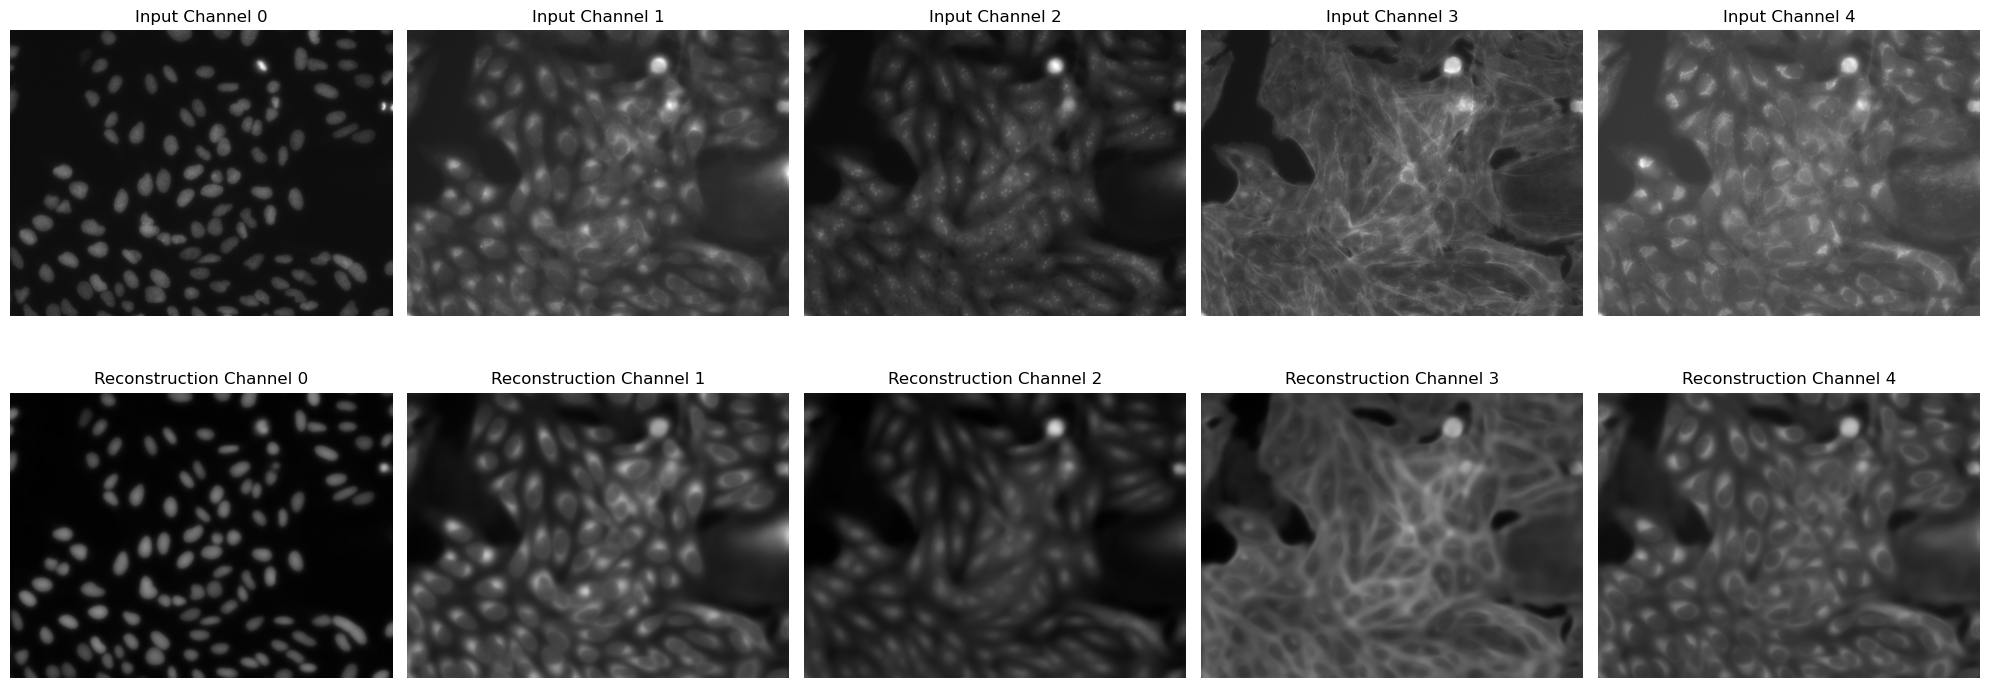


Metadata:
broad_id: BRD-K39120595-304-02-1
compound_name: bithionol
compound_type: INN
smiles: Oc1c(Cl)cc(Cl)cc1Sc1cc(Cl)cc(Cl)c1O
plate_id: 24277
well: P05
site: 4


In [10]:
show_vae_reconstruction(10)